# Advanced Derivatives
## Grouop Project
### Group Members:
- Edoardo Nicoletti 87537
- Alfonso Salcines Gomez Pardo
- Riccardo Mauli
- Zacch Lines

In [1]:
import numpy as np
import pandas as pd
from financepy.utils import OptionTypes
from scipy.stats import norm
import financepy as fp
import matplotlib.pyplot as plt
from financepy.utils import *
from financepy.products.equity import *


####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



### 1. This question is about Black-Scholes-Merton Hedging.


$$
V_0 = \text{bs\_value}(S_0, T, K, r, q, \sigma, \text{OptionTypes.EUROPEAN\_CALL.value})
$$

$$
\Delta_0 = \text{bs\_delta}(S_0, T, K, r, q, \sigma, \text{OptionTypes.EUROPEAN\_CALL.value})
$$


### Parameters:
-  K : Strike price of the option.
- S : Initial stock price.
- r : Risk-free interest rate.
- mu : Drift of the stock price.
- sigma : Volatility of the stock price.
- T : Time to expiry in years.
- N : Hedging frequency per year.
- num_paths : Number of simulation paths.

### (a)

In [8]:
## The following code was taken from notebook 2_A from Okane
stock_price = 100
strike_price = 100
interest_rate = 0.05
dividend_yield = 0.0
volatility = 0.2
T = 1.0


In [9]:
valuation_date = Date(1, 1, 2015)

In [10]:
expiry_date = valuation_date.add_years(T)

In [11]:
call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)

In [12]:
put_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_PUT)

In [13]:
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)

In [14]:
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)

In [16]:
model = BlackScholes(volatility)

In [17]:
call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

10.450575619322274

In [18]:
put_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

5.57351806939368

In [19]:
call_option.delta(valuation_date, stock_price, discount_curve, dividend_curve, model)

0.6368305904551367

In [ ]:
## End of the code from Okane

In [20]:
## Parameters
S = 100
K = 100
r = 0.05
q = 0.0
sigma = 0.2
T = 1.0

In [21]:
def bs_value(S, T, K, r, q, sigma, option_type):
    """Calculate the Black-Scholes value of a European option."""
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

In [22]:
def bs_delta(S, T, K, r, q, sigma, option_type):
    """Calculate the Black-Scholes delta of a European option."""
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == "call":
        return np.exp(-q * T) * norm.cdf(d1)
    elif option_type == "put":
        return -np.exp(-q * T) * norm.cdf(-d1)

In [23]:
call_value = bs_value(S, T, K, r, q, sigma, "call")
call_delta = bs_delta(S, T, K, r, q, sigma, "call")

print(f"Call Option Value: {call_value}")
print(f"Call Option Delta: {call_delta}")

Call Option Value: 10.450583572185565
Call Option Delta: 0.6368306511756191


### (b)

In [25]:
N = 252      
num_paths = 1000
mu = 0.05

In [47]:
def OptionSim(K, S0, r, mu, sigma, T, N):
    """
    Simulates delta hedging of a European call option.
    """
    dt = 1 / N
    timesteps = int(T * N)

    # Simulate stock price path
    Z = np.random.normal(0, 1, timesteps)
    S = np.zeros(timesteps + 1)
    S[0] = S0
    for t in range(1, timesteps + 1):
        S[t] = S[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[t - 1])

    # Initialize portfolio variables
    cash_balance = 0.0
    shares_held = 0.0

    # Hedging process
    for t in range(timesteps):
        T_remaining = T - t * dt
        delta = bs_delta(S[t], T_remaining, K, r, 0, sigma, "call")
        
        # Update shares held and cash balance
        shares_to_buy = delta - shares_held
        cash_balance -= shares_to_buy * S[t]
        shares_held = delta

        # Update cash balance with risk-free growth
        cash_balance *= np.exp(r * dt)

    # Final values
    terminal_stock_price = S[-1]
    portfolio_value = shares_held * S[-1] + cash_balance
    option_payoff = max(S[-1] - K, 0)
    replicating_error = portfolio_value - option_payoff
    
    results = pd.DataFrame({
        "Terminal Stock Price (S(T))": [terminal_stock_price],
        "Option Payoff": [option_payoff],
        "Shares Held": [shares_held],
        "Cash Balance": [cash_balance],
        "Portfolio Value": [portfolio_value],
        "Replicating Error": [replicating_error]
    })

    return results

In [48]:
OptionSim(100,100,0.05,0.05,0.2,1,252)

,Terminal Stock Price (S(T)),Option Payoff,Shares Held,Cash Balance,Portfolio Value,Replicating Error
0,139.665207,39.665207,1.0,0.0,139.665207,100.0


### (c)

In [38]:
def RunOptionSimLoop(K, S0, r, mu, sigma, T, N, num_paths):
    """
    Runs the OptionSim function in a for loop and collects the results.
    """
    results = []  # List to collect results

    for i in range(num_paths):
        result = OptionSim(K, S0, r, mu, sigma, T, N)  # Run OptionSim
        results.append(result)  # Append the DataFrame result

    # Concatenate all results into a single DataFrame
    final_results = pd.concat(results, ignore_index=True)

    return final_results

In [39]:
df_results=RunOptionSimLoop(K, 100, r, mu, sigma, T, N, num_paths)

In [40]:
df_results.head(3)

,Terminal Stock Price (S(T)),Option Payoff,Shares Held,Cash Balance,Portfolio Value,Replicating Error
0,106.547195,6.547195,1.0,2.572317,109.119512,102.572316
1,106.472489,6.472489,1.0,0.000389,106.472876,100.000388
2,117.193698,17.193698,1.0,0.000000,117.193698,100.000000


### (d)

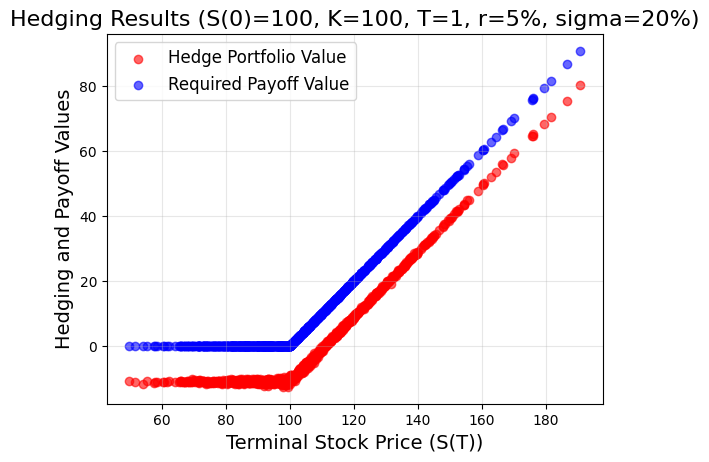

In [15]:
plt.scatter(
    df_results["Terminal Stock Price (S(T))"],
    df_results["Portfolio Value"],
    color='red',
    label="Hedge Portfolio Value",
    alpha=0.6
)

plt.scatter(
    df_results["Terminal Stock Price (S(T))"],
    df_results["Option Payoff"],
    color='blue',
    label="Required Payoff Value",
    alpha=0.6
)

plt.title("Hedging Results (S(0)=100, K=100, T=1, r=5%, sigma=20%)", fontsize=16)
plt.xlabel("Terminal Stock Price (S(T))", fontsize=14)
plt.ylabel("Hedging and Payoff Values", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()